# XGBoost Classifier template
**Example modified from [TDS](https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390)**

In [34]:
# Imports
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
import matplotlib.pyplot as plt

**Load the dataset**

In [2]:
# load dataset
rain = pd.read_csv("data/weatherAUS.csv")

rain.head()
# Create the DMatrix from X and y: df
# df_dmatrix = xgb.DMatrix(data=df.iloc[:,:-1],
#                           label=df.target)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**View the dataset**

In [3]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

The dataset contains weather measures of 10 years from multiple weather stations in Australia. You can either predict whether it will rain tomorrow or today, so there are two targets in the dataset named RainToday, RainTomorrow.

Since we will only be predicting for RainToday, we will drop the other one along with some other features that won't be necessary:

In [4]:
rain.RainToday.value_counts()

No     110319
Yes     31880
Name: RainToday, dtype: int64

**Pre-process the data**

Drop unnecessary columns

In [5]:
# drop unneeded columns
cols_to_drop = ["Date", "Location", "RainTomorrow", "Rainfall"]

rain.drop(cols_to_drop, axis=1, inplace=True)

Handle missing values

In [6]:
# find missing values
missing_props = rain.isna().mean(axis=0)

# set threshold to if missing over 40%
over_threshold = missing_props[missing_props >= 0.4]

# drop those that meet the threshold
rain.drop(over_threshold.index, 
          axis=1, 
          inplace=True)


**Feature engineering**

In [10]:
rain


,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Temp9am,Temp3pm,RainToday
0,13.4,22.9,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,16.9,21.8,No
1,7.4,25.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,17.2,24.3,No
2,12.9,25.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,21.0,23.2,No
3,9.2,28.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,18.1,26.5,No
4,17.5,32.3,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2.8,23.4,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,10.1,22.4,No
145456,3.6,25.3,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,10.9,24.5,No
145457,5.4,26.9,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,12.5,26.1,No
145458,7.8,27.0,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,15.1,26.0,No


In [9]:
rain.RainToday.isna().value_counts()

False    142199
True       3261
Name: RainToday, dtype: int64

Divide data into X, y

In [12]:
X = rain.drop("RainToday", axis=1)
y = rain.RainToday

In [14]:
X.shape,y.shape

((145460, 15), (145460,))

For categorical features: use pipelines to impute the most frequent category, and one hot encode the features

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)), ])

For numeric features: use pipelines to impute the mean

In [16]:
from sklearn.preprocessing import StandardScaler

numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean"))])

**Combine the pipelines with a column transformer**

In [17]:
# isolate the numeric and categorical features
cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

In [18]:
# input the cols into a columntransformer
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

**Apply preprocessing and perform train/test split**

In [19]:
# Apply preprocessing
X_processed = full_processor.fit_transform(X)
y_processed = SimpleImputer(strategy="most_frequent").fit_transform(
    y.values.reshape(-1, 1)
)

# make 1d array
y_processed = y_processed.ravel()

# binarize labels
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()

# update labels to 0, 1
y_processed = labelencoder.fit_transform(y_processed)


# Create the training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, stratify=y_processed, random_state=42
)

In [21]:
y_processed.shape

(145460,)

**Fit default classifier and evaluate**

In [22]:
from sklearn.metrics import accuracy_score

# Declare the evaluation data set
# eval_set = [(X_train, y_train.ravel()),(X_test,y_test.ravel())]

# Initialize default classifier
xgb_cl = xgb.XGBClassifier(subsample=1,
        colsample_bytree=1,
        min_child_weight=1,
        max_depth=6,
        learning_rate=0.3,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='mlogloss')

# Fit the model but stop early if there has been no reduction in error after 10 epochs.
xgb_cl.fit(X_train, y_train) #, eval_metric="error",eval_set=eval_set,verbose=1)

# Predict on test data
preds = xgb_cl.predict(X_test)

# Score
print('Accuracy:',accuracy_score(y_test, preds))

Accuracy: 0.8480956964113846


**Cross-validation and hyperparameter tuning with GridSearchCV**

[Source1](https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/)

Param grid (can be modified)

In [25]:
# Create the parameter dictionary: param_grid
param_grid = {
    'max_depth': range (2, 10, 2),
    'n_estimators': range(60, 180, 60),
    'learning_rate': [0.1, 0.01, 0.05],
}

## other options ##
# param_grid = {
#     "max_depth": [3, 4, 5, 7],
#     "learning_rate": [0.1, 0.01, 0.05],
#     "gamma": [0, 0.25, 1],
#     "reg_lambda": [0, 1, 10],
#     "scale_pos_weight": [1, 3, 5],
#     "subsample": [0.8],
#     "colsample_bytree": [0.5],
# }

# PARAMETERS = {"subsample":[0.5, 0.75, 1],
#               "colsample_bytree":[0.5, 0.75, 1],
#               "max_depth":[2, 6, 12],
#               "min_child_weight":[1,5,15],
#               "learning_rate":[0.3, 0.1, 0.03],
#               "n_estimators":[100]}

# param_grid = {
#     'max_depth': range (2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05],
#     'colsample_bytree':[0.5, 0.75, 1],
# }


Perform the `GridSearchCV` - change cv and param_grid beforehand to make more useful.

In [26]:
from sklearn.model_selection import GridSearchCV

# Init classifier - use 4 threads to speed up training, and set seed
xgb_cl = xgb.XGBClassifier(
        objective="binary:logistic",
        nthread=4,
        seed=42,
        use_label_encoder=False,
        eval_metric='mlogloss'                    
)

# Init Grid Search - only doing 2 folds right now to make it faster
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=10, cv=2, scoring="roc_auc", verbose=True)

# Fit
_ = grid_cv.fit(X_processed, y_processed)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


Show best params and score

In [27]:
grid_cv.best_params_

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 120}

In [28]:
grid_cv.best_score_

0.8425053618815761

Insert best param values manually if needed

In [ ]:
# # Insert the new fixed values to the grid
# param_grid["scale_pos_weight"] = [3]
# param_grid["subsample"] = [0.8]
# param_grid["colsample_bytree"] = [0.5]

# # Give new value ranges to other params
# param_grid["gamma"] = [3, 5, 7]
# param_grid["max_depth"] = [9, 15, 20]
# param_grid["reg_lambda"] = [10, 30, 50]
# param_grid["learning_rate"] = [0.3, 0.5, 0.7, 1]

**Make a final classifier with the best parameters**

In [31]:
final_cl = xgb.XGBClassifier(
    **grid_cv.best_params_,
    objective="binary:logistic",
    colsample_bytree=0.5,
    subsample=0.8,
    nthread=4,
    seed=42,
    use_label_encoder=False,
    eval_metric='mlogloss'        
)

**Fit model and make predictions**

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix

_ = final_cl.fit(X_train, y_train)

preds = final_cl.predict(X_test)

**Make predictions and find accuracy**

In [35]:
# Predict the labels of the test set: preds
preds = final_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.843118


**Confusion matrix**

XGBoost - Classification report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90     28395
           1       0.72      0.47      0.57      7970

    accuracy                           0.84     36365
   macro avg       0.79      0.71      0.74     36365
weighted avg       0.83      0.84      0.83     36365



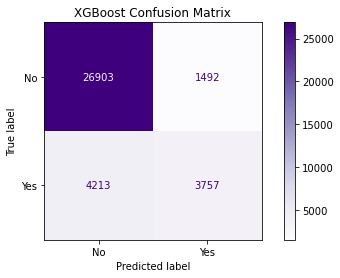

In [36]:
print("XGBoost - Classification report:\n", classification_report(y_test, preds))
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ConfusionMatrixDisplay.from_estimator(final_cl, X_test, y_test, display_labels=['No','Yes'], cmap = plt.cm.Purples, ax=ax)
_ = ax.set_title('XGBoost Confusion Matrix')

**Feature importance**

In [46]:
final_cl.feature_importances_

array([0.04285614, 0.03916642, 0.03804286, 0.02083911, 0.01047168,
       0.15294738, 0.08256998, 0.0366009 , 0.01467057, 0.0324171 ,
       0.02342726, 0.02308796, 0.00381053, 0.00518775, 0.0078768 ,
       0.01789366, 0.01301987, 0.01249261, 0.01094416, 0.00335039,
       0.00634604, 0.0089173 , 0.0068492 , 0.01382124, 0.00997474,
       0.0058685 , 0.00360694, 0.00499297, 0.01099048, 0.01169379,
       0.00723234, 0.0271802 , 0.00545633, 0.01949996, 0.00718335,
       0.00453941, 0.01176423, 0.00511113, 0.00579871, 0.01571981,
       0.01809402, 0.00984876, 0.00485507, 0.01725512, 0.00433505,
       0.00525668, 0.00306962, 0.0264677 , 0.01762637, 0.02398632,
       0.01622175, 0.00493576, 0.00539451, 0.00642465, 0.00327961,
       0.0122928 , 0.01193355, 0.00691562, 0.0069332 , 0.01065401],
      dtype=float32)

<Figure size 1080x720 with 0 Axes>

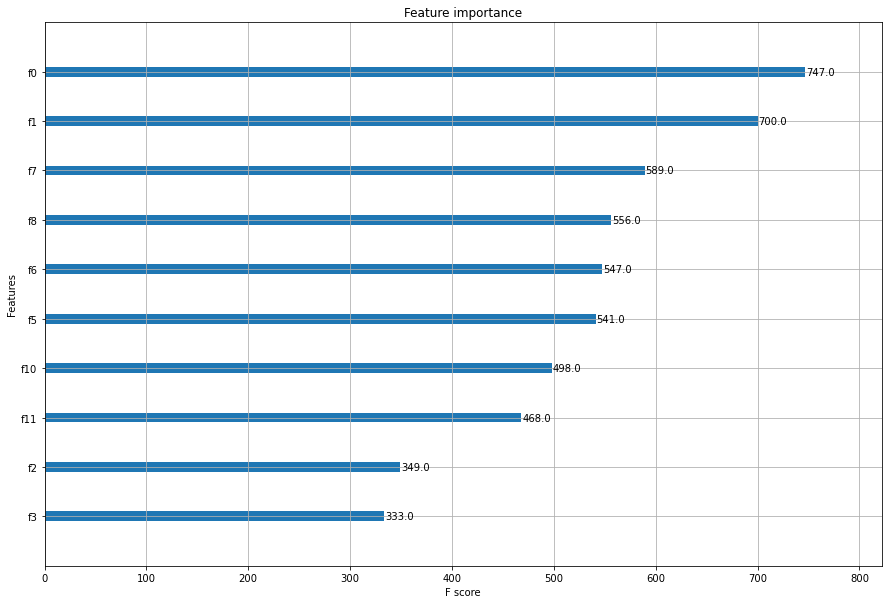

In [62]:
# plot feature importance for top 10 features
plt.figure(figsize=(15,10));
plot_importance(final_cl,max_num_features=10);
plt.rcParams["figure.figsize"] = (15,10);
plt.show();